In [1]:
import numpy as np
import torch
import mm3dtestdata as mm3d
import fusecam
from fusecam.geometric import space
from fusecam.geometric import embedplane
from fusecam.geometric import interpolate
from fusecam.manipimg import rotate_tensor_cube

from fusecam.aiutil import train_scripts
from fusecam.aiutil import ensembling

import matplotlib.pyplot as plt
import einops

from torch.utils.data import TensorDataset, DataLoader

from dlsia.core.networks import sms3d
from dlsia.core import helpers
from dlsia.viz_tools import draw_sparse_network


import torch.nn as nn
import torch.optim as optim



First we need to build test data, low res and high res.

In [2]:
scale = 100
border = 10
radius = 10

sigma_low = 3.0
sigma_high = 0.5

In [3]:
obj = mm3d.balls_and_eggs(scale=scale, border=border, radius=radius, k0=1.0)
_, instance_map_0, class_map_0 = obj.fill()

/tmp/ipykernel_109537/2568210724.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', 3)


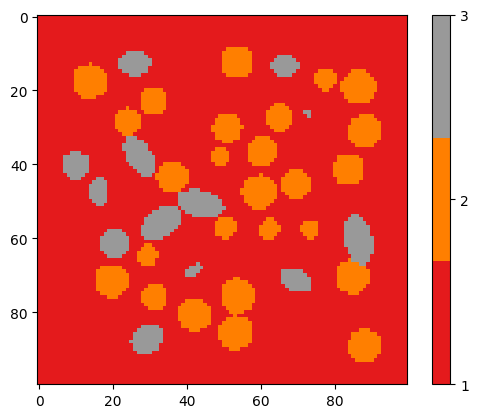

In [4]:
cmap = plt.cm.get_cmap('Set1', 3)
plt.imshow(class_map_0[scale//2,...], cmap=cmap, interpolation='none')
cbar = plt.colorbar(ticks=[0,1,2,3] )#np.arange(np.min(0), np.max(3) + 1))
plt.show()

In [5]:
class_map_low = mm3d.blur_it(class_map_0, sigma=sigma_low)
class_map_high = mm3d.blur_it(class_map_0, sigma=sigma_high)

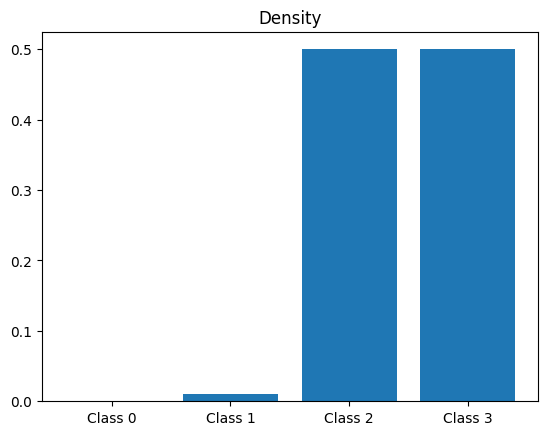

[[0.    0.1   0.1  ]
 [0.5   0.1   0.1  ]
 [0.105 0.1   0.5  ]
 [0.105 0.5   0.1  ]]


In [6]:
tomo_class_0 = np.array([0])
tomo_class_1 = np.array([0.01])
tomo_class_2 = np.array([0.50])
tomo_class_3 = np.array([0.50])
class_actions_tomo = np.column_stack([tomo_class_0,
                                      tomo_class_1,
                                      tomo_class_2,
                                      tomo_class_3]).T

plt.bar( ["Class 0", "Class 1", "Class 2", "Class 3"],class_actions_tomo.ravel() )
plt.title("Density")
plt.show()


spectral_class_0 = np.array([0.0, 0.1, 0.1,])
spectral_class_1 = np.array([0.50, 0.1, 0.1,])
spectral_class_2 = np.array([0.105, 0.1, 0.5,])
spectral_class_3 = np.array([0.105, 0.5, 0.1,])

class_actions_spec = np.column_stack([spectral_class_0,
                                      spectral_class_1,
                                      spectral_class_2,
                                      spectral_class_3]).T
print(class_actions_spec)


In [7]:
low_map = mm3d.compute_weighted_map(class_map_low, class_actions_tomo)
high_map = mm3d.compute_weighted_map(class_map_high, class_actions_spec)

low_map = low_map + mm3d.noise(low_map, 0.01, 0.0)
high_map = high_map + mm3d.noise(high_map, 0.01, 0.0)

print(high_map.shape)

(3, 100, 100, 100)


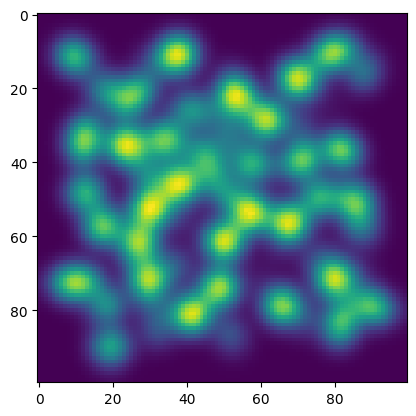

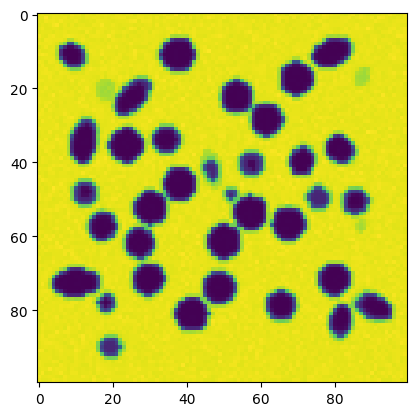

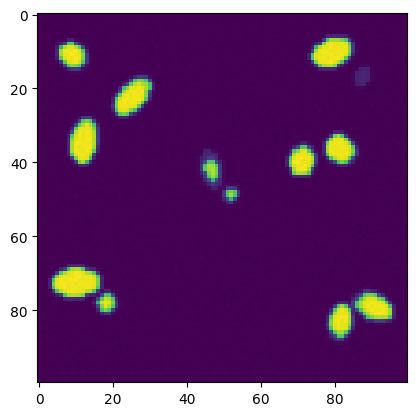

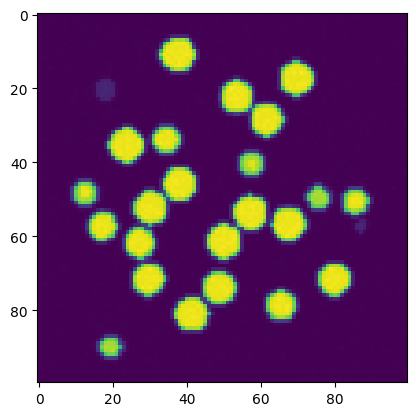

In [8]:
plt.imshow(low_map[0, :,:,scale//2])
plt.show()

plt.imshow(high_map[0, :,:,scale//2])
plt.show()

plt.imshow(high_map[1, :,:,scale//2])
plt.show()

plt.imshow(high_map[2, :,:,scale//2])
plt.show()

Now that we have data, I will use have to make the geometric objects

In [9]:
space_object = space.SpatialVolumeMetric(origin=(0,0,0),
                                         step_size=(1,1,1),
                                         orientation = torch.eye(3),
                                         translation = (0,0,0),
                                        )
plane_object = space.SpatialPlaneMetric(origin=(0,0),
                                         step_size=(1,1),
                                         orientation = torch.eye(2),
                                         translation = (0,0))

Now we have the two geometric objects, I want define a plane and get stuff going

In [10]:
u = torch.linspace(0,scale-1,scale)
U,V = torch.meshgrid(u,u, indexing='ij')
UV = torch.concat([U.flatten().reshape(1,-1), V.flatten().reshape(1,-1)]).T

x = torch.linspace(0,scale-1,scale)
X,Y,Z = torch.meshgrid(x,x,x, indexing="ij")
XYZ = torch.concat([X.flatten().reshape(1,-1), Y.flatten().reshape(1,-1), Z.flatten().reshape(1,-1),]).T 
print(UV.shape, XYZ.shape)

torch.Size([10000, 2]) torch.Size([1000000, 3])


In [11]:
aligner_1 = embedplane.Plane3DAligner(
    normal=[.2, 0.1, 1.0], 
    point_on_plane=[scale//2, scale//2, scale//2 - scale//4]
)
point_on_plane_2D_1 = (scale//2,scale//2)
aligned_points_1 = aligner_1.align_points_to_3d(UV, point_on_plane_2D_1, rotation_angle=0)

aligner_2 = embedplane.Plane3DAligner(
    normal=[0.2, 0.1, 1.0], 
    point_on_plane=[scale//2, scale//2, scale//2 ]
)
point_on_plane_2D_2 = (scale//2,scale//2)
aligned_points_2 = aligner_2.align_points_to_3d(UV, point_on_plane_2D_2, rotation_angle=0)

aligner_3 = embedplane.Plane3DAligner(
    normal=[0.2, 0.1, 1.0], 
    point_on_plane=[scale//2, scale//2, scale//2+scale//4]
)
point_on_plane_2D_3 = (scale//2,scale//2)
aligned_points_3 = aligner_3.align_points_to_3d(UV, point_on_plane_2D_3, rotation_angle=0)


aligner_4 = embedplane.Plane3DAligner(
    normal=[1.0, 0.0, 0.0], 
    point_on_plane=[scale//2-scale//4, scale//2, scale//2]
)
point_on_plane_2D_4 = (scale//2,scale//2)
aligned_points_4 = aligner_4.align_points_to_3d(UV, point_on_plane_2D_4, rotation_angle=0)

aligner_5 = embedplane.Plane3DAligner(
    normal=[1.0, 0.0, 0.0], 
    point_on_plane=[scale//2+scale//4, scale//2, scale//2]
)
point_on_plane_2D_5 = (scale//2,scale//2)
aligned_points_5 = aligner_5.align_points_to_3d(UV, point_on_plane_2D_5, rotation_angle=0)



In [12]:
indices_1, near_dist_1 = interpolate.find_nearest(XYZ, aligned_points_1, 5)
weights_1 = interpolate.compute_weights(near_dist_1, power=3.0, cutoff=2.0)

indices_2, near_dist_2 = interpolate.find_nearest(XYZ, aligned_points_2, 5)
weights_2 = interpolate.compute_weights(near_dist_2, power=3.0, cutoff=2.0)

indices_3, near_dist_3 = interpolate.find_nearest(XYZ, aligned_points_3, 5)
weights_3 = interpolate.compute_weights(near_dist_3, power=3.0, cutoff=2.0)

indices_4, near_dist_4 = interpolate.find_nearest(XYZ, aligned_points_4, 5)
weights_4 = interpolate.compute_weights(near_dist_4, power=3.0, cutoff=2.0)

indices_5, near_dist_5 = interpolate.find_nearest(XYZ, aligned_points_5, 5)
weights_5 = interpolate.compute_weights(near_dist_5, power=3.0, cutoff=2.0)


In [13]:
flat_high_map = einops.rearrange( torch.Tensor(high_map), "C X Y Z -> (X Y Z) C ")

gt_1 = interpolate.inverse_distance_weighting_with_weights_MC(flat_high_map,indices_1,weights_1)
gt_2 = interpolate.inverse_distance_weighting_with_weights_MC(flat_high_map,indices_2,weights_2)
gt_3 = interpolate.inverse_distance_weighting_with_weights_MC(flat_high_map,indices_3,weights_3)
gt_4 = interpolate.inverse_distance_weighting_with_weights_MC(flat_high_map,indices_4,weights_4)
gt_5 = interpolate.inverse_distance_weighting_with_weights_MC(flat_high_map,indices_5,weights_5)


In [14]:
print(gt_1.shape)

torch.Size([10000, 3])


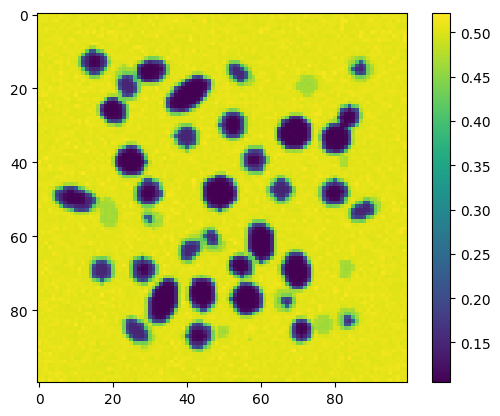

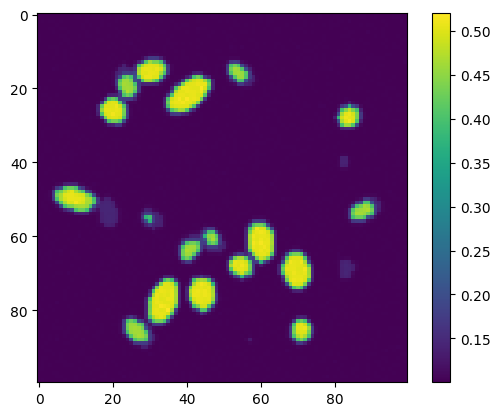

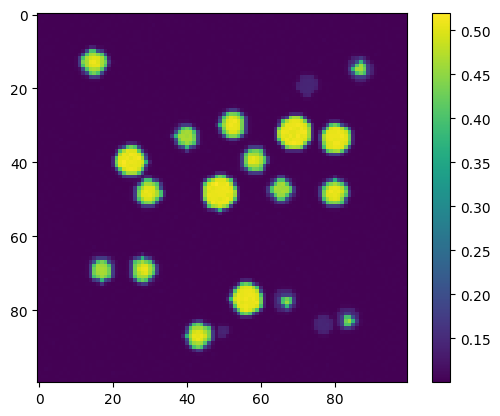

In [15]:
f_1= einops.rearrange(gt_5, "(X Y) C -> C X Y ",X=scale, Y=scale)
plt.imshow(f_1.numpy()[0] )
plt.colorbar()
plt.show()
plt.imshow(f_1.numpy()[1] )
plt.colorbar()
plt.show()
plt.imshow(f_1.numpy()[2] )
plt.colorbar()
plt.show()





In [16]:
my_3d_maps = torch.concat([torch.Tensor(low_map).unsqueeze(0),
                          ])

my_2d_maps = torch.concat([gt_1,
                           gt_2,
                           gt_3,gt_4, gt_5
                          ]).unsqueeze(0)

my_weights = torch.concat([weights_1, weights_2,  weights_3, weights_4,  weights_5]).unsqueeze(0)

my_indices = torch.concat([indices_1, indices_2, indices_3, indices_4, indices_5]).unsqueeze(0)

print(my_indices.shape, my_weights.shape)
                           

torch.Size([1, 50000, 5]) torch.Size([1, 50000, 5])


In [17]:
my_data = TensorDataset(my_3d_maps, my_2d_maps, my_weights, my_indices)                          
data_loader = DataLoader(my_data, batch_size=1) 

In [18]:
n_networks = 5
networks = ensembling.construct_3dsms_ensembler(n_networks=n_networks,
                                                in_channels=1,
                                                out_channels=3,
                                                layers = 20,
                                                alpha=0.00,
                                                gamma=0.00,
                                                hidden_channels=[10],
                                                #parameter_bounds=[250000,300000],
                                                network_type="Regression"
                                               )

In [19]:
for net in networks:
    print( helpers.count_parameters(net) )
    #a,b,c = draw_sparse_network.draw_network(net)
    
    

291727
534157
702587
405127
542377


In [20]:
for net in networks:
    
    
    loss_function = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    train_scripts.train_volume_on_slice(net, 
            loss_function, 
            optimizer, 
            data_loader, 
            50, 
            interpolate.inverse_distance_weighting_with_weights, device='cuda:0')
    
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    train_scripts.train_volume_on_slice(net, 
            loss_function, 
            optimizer, 
            data_loader, 
            50, 
            interpolate.inverse_distance_weighting_with_weights, device='cuda:0')

    loss_function = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    train_scripts.train_volume_on_slice(net, 
            loss_function, 
            optimizer, 
            data_loader, 
            50, 
            interpolate.inverse_distance_weighting_with_weights, device='cuda:0')

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    train_scripts.train_volume_on_slice(net, 
            loss_function, 
            optimizer, 
            data_loader, 
            250, 
            interpolate.inverse_distance_weighting_with_weights, device='cuda:0')
    print()
    print()

    

Epoch [1/50], Loss: 0.3036152720451355
Epoch [2/50], Loss: 0.6608079671859741
Epoch [3/50], Loss: 0.33405107259750366
Epoch [4/50], Loss: 0.25876113772392273
Epoch [5/50], Loss: 0.1586773544549942
Epoch [6/50], Loss: 0.15963396430015564
Epoch [7/50], Loss: 0.14033830165863037
Epoch [8/50], Loss: 0.11720200628042221
Epoch [9/50], Loss: 0.10322368144989014
Epoch [10/50], Loss: 0.09438528120517731
Epoch [11/50], Loss: 0.09686782211065292
Epoch [12/50], Loss: 0.08279037475585938
Epoch [13/50], Loss: 0.06873027980327606
Epoch [14/50], Loss: 0.06581604480743408
Epoch [15/50], Loss: 0.07272516936063766
Epoch [16/50], Loss: 0.0640290305018425
Epoch [17/50], Loss: 0.05805318430066109
Epoch [18/50], Loss: 0.061540164053440094
Epoch [19/50], Loss: 0.06154905632138252
Epoch [20/50], Loss: 0.05841466784477234
Epoch [21/50], Loss: 0.05732494220137596
Epoch [22/50], Loss: 0.04919736459851265
Epoch [23/50], Loss: 0.05525193363428116
Epoch [24/50], Loss: 0.05593046918511391
Epoch [25/50], Loss: 0.04563

Epoch [48/250], Loss: 0.0013801915338262916
Epoch [49/250], Loss: 0.0013589711161330342
Epoch [50/250], Loss: 0.00133136089425534
Epoch [51/250], Loss: 0.0013051416026428342
Epoch [52/250], Loss: 0.0012843628646805882
Epoch [53/250], Loss: 0.0012676259502768517
Epoch [54/250], Loss: 0.0012519763549789786
Epoch [55/250], Loss: 0.0012311239261180162
Epoch [56/250], Loss: 0.0012077846331521869
Epoch [57/250], Loss: 0.0011867489665746689
Epoch [58/250], Loss: 0.0011706269579008222
Epoch [59/250], Loss: 0.0011575670214369893
Epoch [60/250], Loss: 0.0011431027669459581
Epoch [61/250], Loss: 0.0011255593271926045
Epoch [62/250], Loss: 0.001105190021917224
Epoch [63/250], Loss: 0.0010881462367251515
Epoch [64/250], Loss: 0.0010756355477496982
Epoch [65/250], Loss: 0.001065119169652462
Epoch [66/250], Loss: 0.001054248888976872
Epoch [67/250], Loss: 0.0010391337564215064
Epoch [68/250], Loss: 0.0010215709917247295
Epoch [69/250], Loss: 0.001006455160677433
Epoch [70/250], Loss: 0.00099593505728

Epoch [232/250], Loss: 0.00038230439531616867
Epoch [233/250], Loss: 0.0003818059340119362
Epoch [234/250], Loss: 0.0003829683701042086
Epoch [235/250], Loss: 0.00038093249895609915
Epoch [236/250], Loss: 0.00037667981814593077
Epoch [237/250], Loss: 0.0003748850431293249
Epoch [238/250], Loss: 0.0003752358607016504
Epoch [239/250], Loss: 0.00037421390879899263
Epoch [240/250], Loss: 0.0003713554178830236
Epoch [241/250], Loss: 0.00036870973417535424
Epoch [242/250], Loss: 0.00036770710721611977
Epoch [243/250], Loss: 0.00036733158049173653
Epoch [244/250], Loss: 0.00036595528945326805
Epoch [245/250], Loss: 0.0003636476758401841
Epoch [246/250], Loss: 0.00036147082573734224
Epoch [247/250], Loss: 0.0003604177909437567
Epoch [248/250], Loss: 0.0003599264600779861
Epoch [249/250], Loss: 0.0003588340769056231
Epoch [250/250], Loss: 0.00035699232830666006


Epoch [1/50], Loss: 0.26005807518959045
Epoch [2/50], Loss: 0.6021292805671692
Epoch [3/50], Loss: 0.6619328856468201
Epoch [4/50], L

Epoch [28/250], Loss: 0.004998053424060345
Epoch [29/250], Loss: 0.004972860682755709
Epoch [30/250], Loss: 0.004950500559061766
Epoch [31/250], Loss: 0.004932743962854147
Epoch [32/250], Loss: 0.004917968530207872
Epoch [33/250], Loss: 0.0049040899612009525
Epoch [34/250], Loss: 0.0048902155831456184
Epoch [35/250], Loss: 0.004875532351434231
Epoch [36/250], Loss: 0.0048594349063932896
Epoch [37/250], Loss: 0.004842299968004227
Epoch [38/250], Loss: 0.004825032316148281
Epoch [39/250], Loss: 0.004808610770851374
Epoch [40/250], Loss: 0.004793411120772362
Epoch [41/250], Loss: 0.004779490642249584
Epoch [42/250], Loss: 0.004766893107444048
Epoch [43/250], Loss: 0.004754636436700821
Epoch [44/250], Loss: 0.0047422912903130054
Epoch [45/250], Loss: 0.004729589447379112
Epoch [46/250], Loss: 0.004716773051768541
Epoch [47/250], Loss: 0.004703997168689966
Epoch [48/250], Loss: 0.004691741429269314
Epoch [49/250], Loss: 0.00468017952516675
Epoch [50/250], Loss: 0.004669053480029106
Epoch [5

Epoch [215/250], Loss: 0.0016368969809263945
Epoch [216/250], Loss: 0.0016410150565207005
Epoch [217/250], Loss: 0.0016417372971773148
Epoch [218/250], Loss: 0.0016321809962391853
Epoch [219/250], Loss: 0.0016145854024216533
Epoch [220/250], Loss: 0.0015953233232721686
Epoch [221/250], Loss: 0.001577814924530685
Epoch [222/250], Loss: 0.0015619919868186116
Epoch [223/250], Loss: 0.0015511582605540752
Epoch [224/250], Loss: 0.0015504404436796904
Epoch [225/250], Loss: 0.0015529738739132881
Epoch [226/250], Loss: 0.001555412309244275
Epoch [227/250], Loss: 0.0015636598691344261
Epoch [228/250], Loss: 0.0015820220578461885
Epoch [229/250], Loss: 0.0016019243048503995
Epoch [230/250], Loss: 0.001579451491124928
Epoch [231/250], Loss: 0.0015276008052751422
Epoch [232/250], Loss: 0.001497821882367134
Epoch [233/250], Loss: 0.0015023397281765938
Epoch [234/250], Loss: 0.0015143129276111722
Epoch [235/250], Loss: 0.0015198823530226946
Epoch [236/250], Loss: 0.0015108301304280758
Epoch [237/250

OutOfMemoryError: CUDA out of memory. Tried to allocate 434.00 MiB. GPU 0 has a total capacty of 23.46 GiB of which 148.69 MiB is free. Process 17354 has 528.00 MiB memory in use. Including non-PyTorch memory, this process has 22.28 GiB memory in use. Of the allocated memory 17.97 GiB is allocated by PyTorch, and 3.98 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
m = 0.0
s = 0.0

allo = []
with torch.no_grad():
    for net in networks[0:2]:
        tmp3 = torch.exp(net.cpu()(torch.Tensor(low_map).unsqueeze(0)))
        allo.append(tmp3)
        m += tmp3
        s += tmp3**2.0

In [23]:
m = m/2 #n_networks
s = torch.sqrt(s/2 - m*m)

In [24]:
print(low_map.shape, m.shape)

import napari
vv = napari.view_image(m.numpy()[0,0,...])
vv.add_image(m.numpy()[0,1,...])
vv.add_image(m.numpy()[0,2,...])

vv.add_image(s.numpy()[0,0,...])
vv.add_image(s.numpy()[0,1,...])
vv.add_image(s.numpy()[0,2,...])


vv.add_image(high_map[0])
vv.add_image(high_map[1])
vv.add_image(high_map[2])
vv.add_image(low_map[0])

(1, 100, 100, 100) torch.Size([1, 3, 100, 100, 100])


<Image layer 'Image [9]' at 0x7ff93c296970>

In [ ]:
vv.add_image(low_map[0])

In [ ]:
import numpy as np
from scipy import stats

def z_to_p(z_score):
    p_value = 1.0 - stats.norm.sf((z_score))  # sf is the survival function, which is 1-cdf
    return p_value

In [ ]:
zero_mask = (m - 3*s) < 0.05
zero_mask = 1.0 - zero_mask.numpy()

z_score = (m.numpy()[0] - 0.35) / ( s.numpy()[0]+1e-3)
pval =  z_to_p(z_score)print(my_2d_maps.shape)

#z_score = zero_mask*np.exp(-z_score**2.0)



In [ ]:
import napari

v = napari.view_image(low_map)
v.add_image(m.numpy()[0])
v.add_image(s.numpy()[0])
v.add_image(high_map)
v.add_image( pval )

In [ ]:
v.add_image( z_score )

In [ ]:
plt.imshow(m.numpy()[0, 0,:,:,scale//2-15])
plt.colorbar()
plt.show()

plt.imshow(high_map[0,:,:,scale//2-15])
plt.colorbar()
plt.show()


plt.imshow(low_map[0,:,:,scale//2-15])
plt.colorbar()
plt.show()